In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Optional ensemble models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")


Dataset shape: (36168, 18)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,28687,29.0,services,single,secondary,no,-205.0,no,no,cellular,30.0,jan,194.0,1.0,-1.0,0.0,unknown,0
1,9305,53.0,blue-collar,married,primary,no,0.0,yes,no,unknown,5.0,jun,285.0,2.0,-1.0,0.0,unknown,0
2,41426,55.0,management,married,NaN,no,2587.0,no,no,cellular,4.0,sep,328.0,2.0,94.0,2.0,success,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         36168 non-null  int64  
 1   age        35770 non-null  float64
 2   job        35734 non-null  object 
 3   marital    35698 non-null  object 
 4   education  35662 non-null  object 
 5   default    35625 non-null  object 
 6   balance    35589 non-null  float64
 7   housing    35553 non-null  object 
 8   loan       35517 non-null  object 
 9   contact    35481 non-null  object 
 10  day        35445 non-null  float64
 11  month      35408 non-null  object 
 12  duration   35372 non-null  float64
 13  campaign   35336 non-null  float64
 14  pdays      35300 non-null  float64
 15  previous   35264 non-null  float64
 16  poutcome   35228 non-null  object 
 17  y          36168 non-null  int64  
dtypes: float64(7), int64(2), object(9)
memory usage: 5.0+ MB


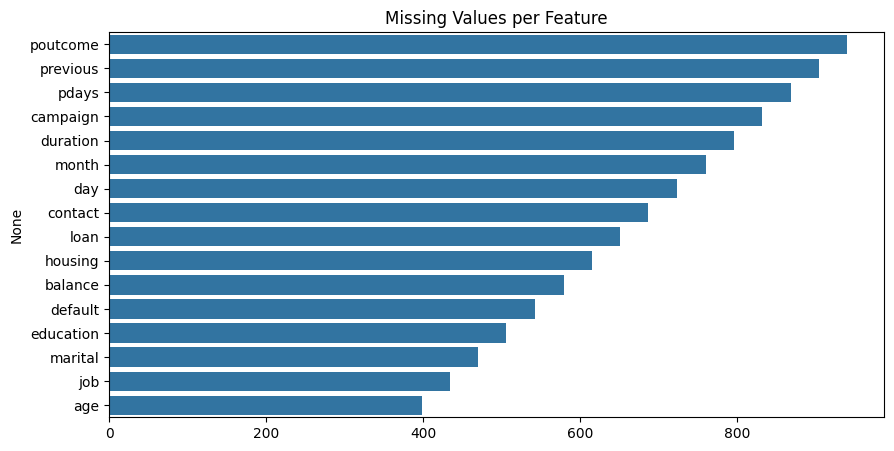

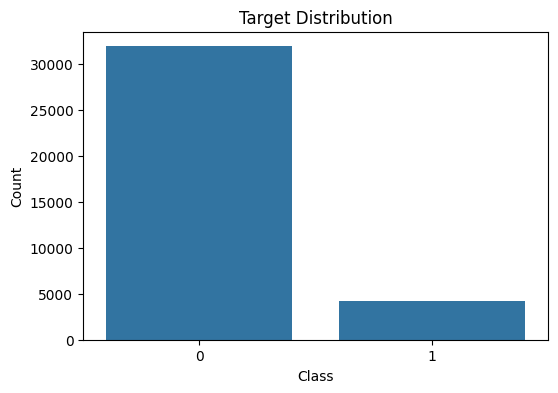

Class proportions:
y
0    0.883
1    0.117
Name: proportion, dtype: float64


In [17]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# === Basic Info ===
print("Dataset shape:", df_train.shape)
display(df_train.head(3))
df_train.info()

# === Missing Values ===
missing = df_train.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
plt.figure(figsize=(10,5))
sns.barplot(x=missing.values, y=missing.index)
plt.title("Missing Values per Feature")
plt.show()

# === Target Distribution ===
plt.figure(figsize=(6,4))
sns.countplot(x=df_train['y'])
plt.title("Target Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Class proportions:")
print(df_train['y'].value_counts(normalize=True).round(3))


In [4]:
# === Feature Summary ===
num_cols = df_train.select_dtypes(include=['int64','float64']).columns
cat_cols = df_train.select_dtypes(include=['object']).columns

print(f"Numerical features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")


Numerical features: 9
Categorical features: 9


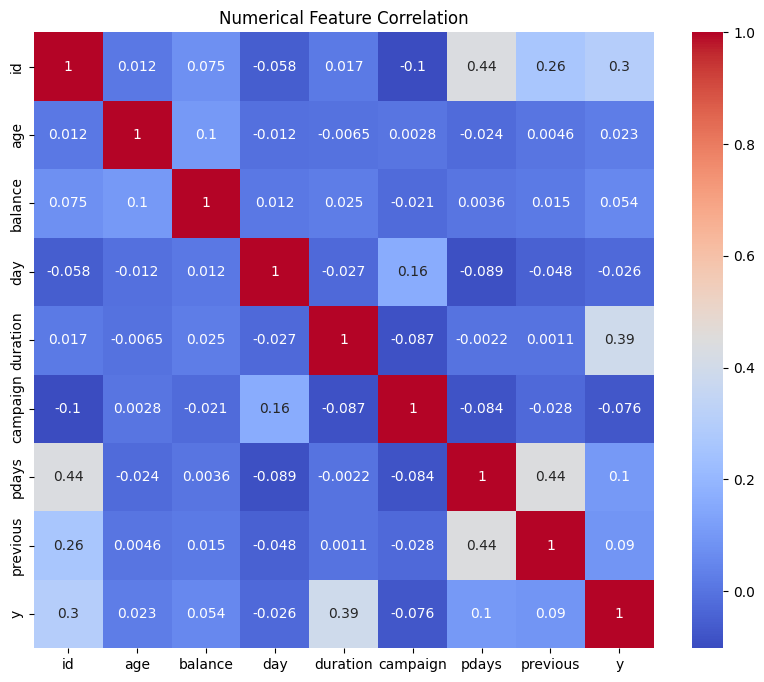

In [6]:
# === Correlation (Numerical) ===
plt.figure(figsize=(10,8))
corr = df_train[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("Numerical Feature Correlation")
plt.show()


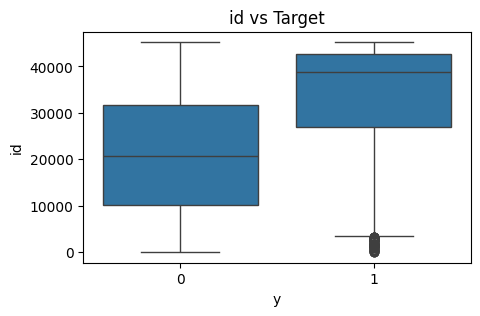

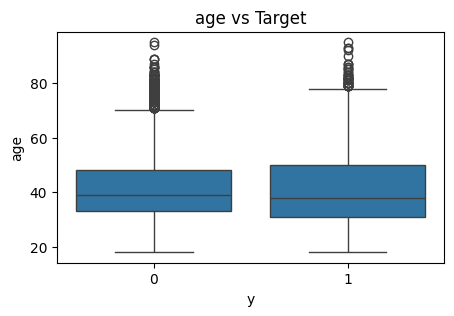

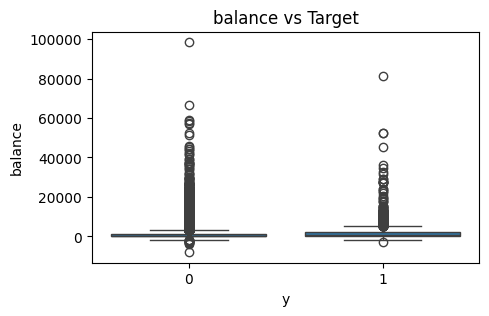

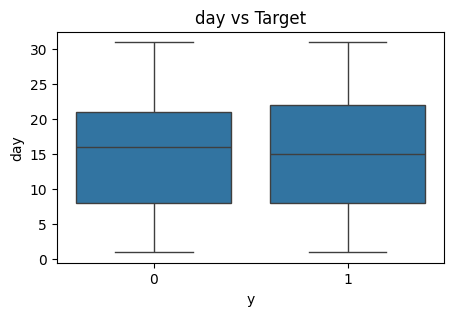

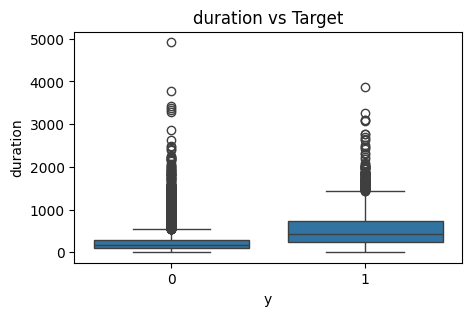

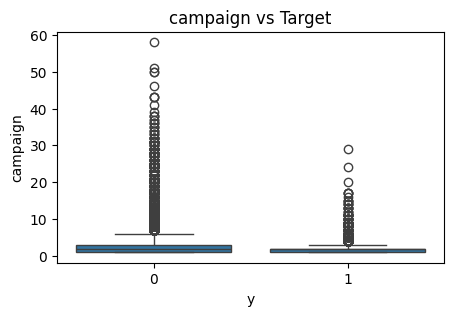

In [8]:
# === Numerical Features vs Target ===
for col in num_cols[:6]:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='y', y=col, data=df_train)
    plt.title(f"{col} vs Target")
    plt.show()


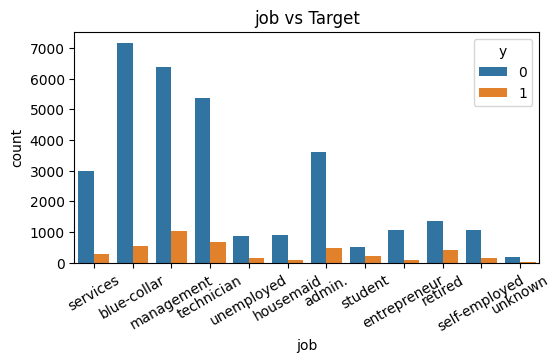

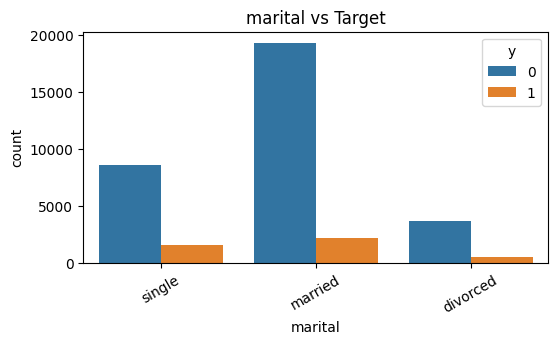

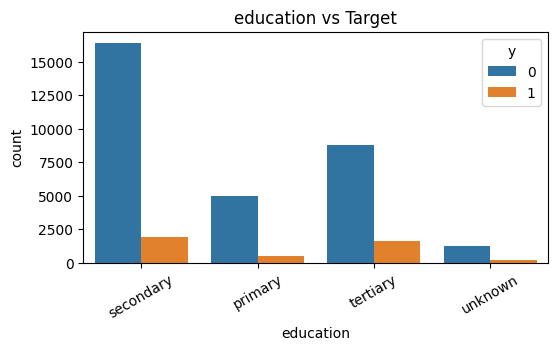

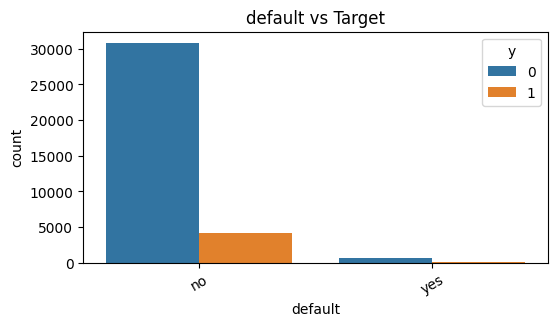

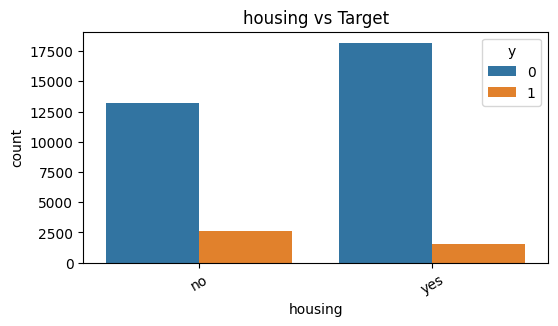

In [9]:
# === Categorical Features vs Target ===
for col in cat_cols[:5]:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='y', data=df_train)
    plt.title(f"{col} vs Target")
    plt.xticks(rotation=30)
    plt.show()


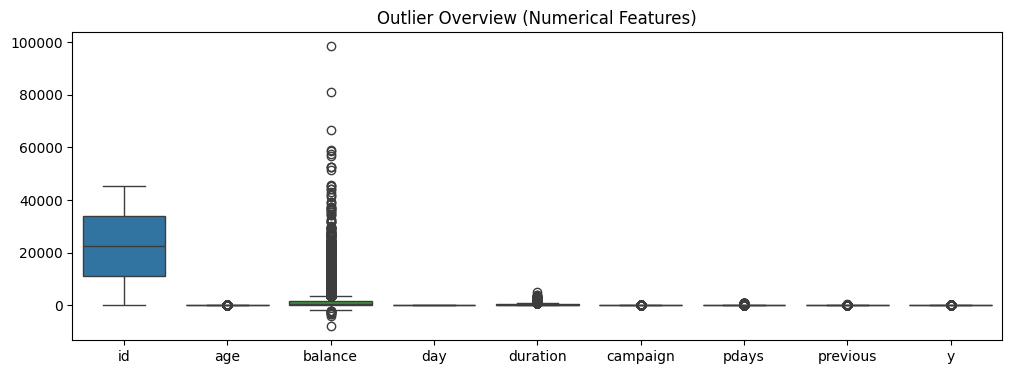

In [10]:
# === Outlier Detection ===
plt.figure(figsize=(12,4))
sns.boxplot(data=df_train[num_cols])
plt.title("Outlier Overview (Numerical Features)")
plt.show()


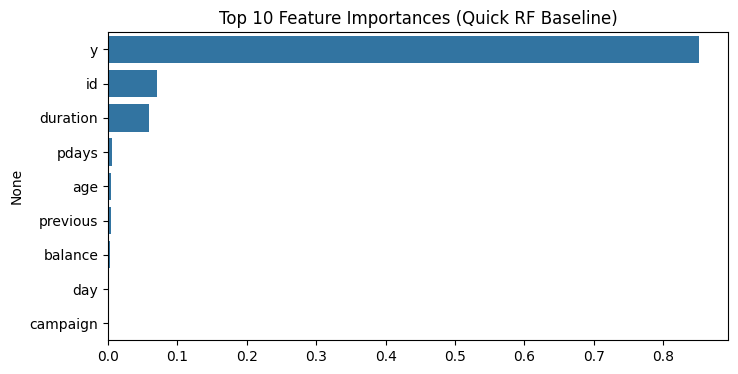

In [12]:
# === Quick Feature Importance (RF baseline) ===
le = LabelEncoder()
y_encoded = le.fit_transform(df_train['y'])

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(df_train[num_cols].fillna(0), y_encoded)

importances = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Feature Importances (Quick RF Baseline)")
plt.show()


In [ ]:
# FE??

In [25]:
def build_preprocessor(X, num_strategy="median", scaler="standard", cat_strategy="most_frequent"):
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy=num_strategy)),
        ("scaler", StandardScaler() if scaler=="standard" else MinMaxScaler())
    ])

    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy=cat_strategy)),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])
    return preprocessor



def build_models():
    models = {
        "logreg": LogisticRegression(max_iter=500),
        "rf": RandomForestClassifier(n_estimators=300, random_state=42),
        "xgb": XGBClassifier(
            n_estimators=400, learning_rate=0.05, random_state=42, 
            use_label_encoder=False, eval_metric='mlogloss'
        ),
        "gb": GradientBoostingClassifier(n_estimators=300, random_state=42),
        "svc": SVC(probability=True, kernel='rbf')
    }
    return models




def build_voting_ensemble(models):
    estimators = [(name, m) for name, m in models.items()]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')
    return voting_clf

def build_stacking_ensemble(models):
    estimators = [(name, m) for name, m in models.items()]
    final_estimator = LogisticRegression(max_iter=500)
    stack_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
    return stack_clf


def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="weighted")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    return acc, f1


def generate_submission(model, preprocessor, df_train, df_test):
    X_train = df_train.drop(columns=["id", "y"])
    y_train = df_train["y"]
    X_test = df_test.copy()
    
    X_train_proc = preprocessor.transform(X_train, y_train)
    X_test_proc = preprocessor.transform(X_test)
    

    model.fit(X_train_proc, y_train)

    y_pred = model.predict(X_test_proc)
  
    # Decode label ke format seperti sample_submission
    label_map = {0: "no", 1: "yes"}
    y_pred_decoded = [label_map[v] for v in y_pred]

    # Create submission
    submission = pd.DataFrame({
        "id": df_test["id"],
        "y": y_pred_decoded
    })
    submission.to_csv("submission.csv", index=False)
    print("✅ Submission saved: submission.csv")




In [14]:
import csv

def log_experiment(version, model_name, ensemble_type, acc, f1, notes):
    with open("experiment_log.csv", "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([version, model_name, ensemble_type, acc, f1, notes])


In [ ]:
import joblib

# # === 1. Feature Engineering ===
# df_train = feature_engineering(df_train)
# df_test = feature_engineering(df_test)

# === 2. Split Data ===
X = df_train.drop(columns=["id", "y"])
y = df_train["y"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === 3. Preprocess ===
preprocessor = build_preprocessor(X_train)
X_train_proc = preprocessor.fit_transform(X_train, y_train)
X_val_proc = preprocessor.transform(X_val)

# === 4. Build Base Models ===
models = build_models()

# === 5. Build Ensemble ===
voting_model = build_voting_ensemble(models)
stacking_model = build_stacking_ensemble(models)

# === 6. Evaluate (example with stacking) ===
acc, f1 = evaluate_model(stacking_model, X_train_proc, y_train, X_val_proc, y_val)

# === 7. Log Experiment ===
log_experiment("v1", "stacking", "LogReg Meta", acc, f1, "Baseline ensemble")


Accuracy: 0.9103
F1 Score: 0.9038

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6388
           1       0.66      0.48      0.55       846

    accuracy                           0.91      7234
   macro avg       0.80      0.72      0.75      7234
weighted avg       0.90      0.91      0.90      7234



In [24]:
generate_submission(stacking_model, preprocessor, df_train, df_test)

✅ Submission saved: submission.csv
